In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy.stats as sst
import matplotlib.pyplot as plt
import os
import os.path as osp
from __future__ import print_function
from __future__ import division
import six
from datetime import datetime
import cnv_util as util
reload(util)

<module 'cnv_util' from 'cnv_util.pyc'>

## Reading TSV files 

In [3]:
CWD = osp.join(osp.expanduser('~'), 'documents','grants_projects','roberto_projects', \
               'guillaume_huguet_CNV','27Oct2015')
filename = '20151027_Imagen_Annot_per_genes_MMAP_HI_TADA.txt'
fullfname = osp.join(CWD, filename)

In [4]:
arr_haplo = np.loadtxt(fullfname, dtype='str', comments=None, delimiter='\Tab', 
                 converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)

### some basic check for the columns of interest 

In [5]:
EXPECTED_LINES = 30752
expected_nb_values = EXPECTED_LINES - 1 
assert arr_haplo.shape[0] == EXPECTED_LINES
line0 = arr_haplo[0].split('\t')
print(line0)

idxs = {}
for col_name in line0:
    idxs[col_name] = line0.index(col_name)

i_haplo = line0.index('Haplosuff_V3')
i_mmap = line0.index('MMAP_signature')
i_per_gene = line0.index('Per_Genes')
i_score = line0.index('Max_Score')
print(i_haplo, i_mmap, i_per_gene)
print(idxs)

['IID_Projet', 'IID_Imagen_Merged_Pe_Qu', 'Chromosome', 'Loci_Start', 'Loci_Stop', 'Concat_CN=Type', 'Concat#SNP', 'Max_Score', 'All_Gene', 'Per_Genes', 'MMAP_signature', 'Haplosuff_V3', 'tadaFdrAscSscExomeSscAgpSmallDel']
11 10 9
{'tadaFdrAscSscExomeSscAgpSmallDel': 12, 'Loci_Stop': 4, 'Haplosuff_V3': 11, 'MMAP_signature': 10, 'IID_Projet': 0, 'Concat_CN=Type': 5, 'Concat#SNP': 6, 'All_Gene': 8, 'IID_Imagen_Merged_Pe_Qu': 1, 'Loci_Start': 3, 'Per_Genes': 9, 'Max_Score': 7, 'Chromosome': 2}


In [6]:
# check that all lines have the same number of tab separated elements 
larr =  np.asarray([len(arr_haplo[i].split('\t')) for i in range(arr_haplo.shape[0])])
assert not (larr - larr[0]).any() # all element have the same value 

In [7]:
haplo = np.asarray([line.split('\t')[i_haplo] for line in arr_haplo[1:]])
mmap = np.asarray([line.split('\t')[i_mmap] for line in arr_haplo[1:]])
# print(np.unique(scores))
assert len(haplo) == expected_nb_values
assert len(mmap) == expected_nb_values

In [8]:
# i_ND = np.where(haplo == 'ND')
haplo_is_ND = (haplo == 'ND')
haplo_not_ND = (haplo != 'ND')
# print(a_ND.shape, i_ND[0].shape)
print(haplo.shape, expected_nb_values, haplo[haplo_is_ND].shape)

(30751,) 30751 (7951,)


In [9]:
haplo_flt = [util.str2floats(h, sep=' ', comma2point=True)[0] for h in haplo[haplo_not_ND]]
# _ = plt.hist(haplo_flt, bins=50)

In [10]:
reload(util)
#get_col_vals(col_name, array, comma2point=True, sep=' ', exclude=None, val_len=None)
haplo_check = util.get_col_vals('Haplosuff_V3', arr_haplo, exclude='ND',val_len=1)
assert np.all(np.abs(haplo_check-haplo_flt)<np.finfo('float').eps)

to_keep.shape (30751,) number to keep:  22800



## From here : should be the same as CNV_Guillaume nb

In [11]:
reload(util)
scores = util.get_col_vals('Max_Score', arr_haplo, exclude='',val_len=None)
print(scores.max(), scores.min(), (scores<=np.finfo(float).eps).sum())

#h = plt.hist(scores, bins=100, range=(0,150))

#h = plt.hist(clean_score[clean_score < 60], bins=100)

to_keep.shape (30751,) number to keep:  30124
5602.56 15.0 0


In [12]:
p_cnv = util._build_dict_prob_cnv()
score2prob = util.create_score2prob_lin(p_cnv)
p_scores = [score2prob(sc) for sc in scores]
#h = plt.hist(p_scores, bins=100)

# check score2prob function
#xs = np.linspace(1,50,50)
#plt.plot(xs, [score2prob(x) for x in xs])

__QUESTION Guillaume:__

Aucun CNV qui ont un score de "zero" dans ce fichier?

## Finally, putting things together 

In [13]:
defaultarg = {'pi':0.1, 'beta':0.8}
util.danger_score('.5', pval2score=util.pH1_with_apriori, argvals=defaultarg)

0.042553191489361694

In [14]:
#names_from = ['START', 'STOP', "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]

#---------- CNV uniques ? 
names_from =  ['Chromosome', 'Loci_Start', 'Loci_Stop']
cnv_names = util.make_uiid(arr_haplo, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))


with names from:  ['Chromosome', 'Loci_Start', 'Loci_Stop']
we have 5965 unique elements out of 30751 rows in the tsv


### Create a dict of the cnv

In [15]:
print(idxs)

{'tadaFdrAscSscExomeSscAgpSmallDel': 12, 'Loci_Stop': 4, 'Haplosuff_V3': 11, 'MMAP_signature': 10, 'IID_Projet': 0, 'Concat_CN=Type': 5, 'Concat#SNP': 6, 'All_Gene': 8, 'IID_Imagen_Merged_Pe_Qu': 1, 'Loci_Start': 3, 'Per_Genes': 9, 'Max_Score': 7, 'Chromosome': 2}


In [16]:
from collections import OrderedDict
reload(util)
cnv = OrderedDict()
names_from =  ['Chromosome', 'Loci_Start', 'Loci_Stop']
                        #, "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]

bad_lines_scr = []
bad_lines_dgr = []
pb_dgr = 0
pb_scr = 0
for line in arr_haplo[1:]:

    scrfl = util.get_one_col_val(idxs['Max_Score'], line, 
                            comma2point=True, sep=' ', 
                            exclude='', val_len=1)
    
    dgr = util.get_one_col_val(idxs['MMAP_signature'], line, 
                            comma2point=True, sep=' ', 
                            exclude='ND', val_len=1)
    
    if (not scrfl):
        pb_scr += 1
        bad_lines_scr.append(line)
    if (not dgr):
        pb_dgr += 1
        bad_lines_dgr.append(line)
    if (not scrfl) or (not dgr):
        continue
    
    cnv_iid = util.make_uiid(line, names_from, arr_haplo[0])
    
    try:
        p_dgr = util.pH1_with_apriori(dgr, pi=.5, beta=.8)
        add_cnv = ( p_dgr, score2prob(scrfl) )
    except:
        print(dgr, scrfl)
        raise

    if cnv_iid in cnv.keys():
        cnv[cnv_iid].append(add_cnv)
    else:
        cnv[cnv_iid] = [add_cnv]

In [17]:
len(bad_lines_scr), pb_scr

(627, 627)

In [18]:
#print(line0)
#print(bad_lines_scr[0])
print(zip(line0, bad_lines_dgr[2].split('\t')))

[('IID_Projet', '000089762809'), ('IID_Imagen_Merged_Pe_Qu', '89762809-660Wq'), ('Chromosome', 'X'), ('Loci_Start', '108804429'), ('Loci_Stop', '108876094'), ('Concat_CN=Type', '3'), ('Concat#SNP', '8'), ('Max_Score', '21,969'), ('All_Gene', 'ACSL4'), ('Per_Genes', 'ACSL4'), ('MMAP_signature', 'ND'), ('Haplosuff_V3', '0,156'), ('tadaFdrAscSscExomeSscAgpSmallDel', '0,933969163')]


In [19]:
print('number of cnv', len(cnv))
print([(k,v) for k,v in cnv.items()[:5]])

number of cnv 5730
[('19_63523631_63588524', [(0.16666666666666663, 0.31349457142857134), (0.16666666666666663, 0.31349457142857134), (0.16666666666666663, 0.31349457142857134), (0.16666666666666663, 0.31349457142857134), (0.16666666666666663, 0.31349457142857134)]), ('12_8975801_9180220', [(0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714)]), ('12_9045199_9440339', [(0.9953066910169112, 1.0), (0.9928003853455415, 1.0), (0.983928695631999, 1.0), (0.9953066910169112, 1.0), (0.983928695631999, 1.0), (0.9953066910169112, 1.0), (0.983928695631999, 1.0), (0.983928695631999, 1.0), (0.983928695631999, 1.0), (0.983928695631999, 1.0)]), ('3_139307462_139508086', [(0.2507496367258369, 0.22925457142857142), (0.2507496367258369, 0.22925457142857142), (0.2507496367258369, 0.22925457142857142), (0

### Create a dictionary of the subjects - 

#### Histogram of the number of cnv used to compute dangerosity

5730
1026


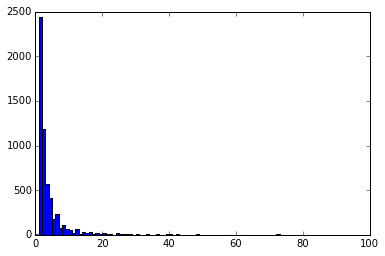

In [20]:
print(len(cnv))
nbcnv = [len(cnv[sb]) for sb in cnv]
hist = plt.hist(nbcnv, bins=100, range=(0,100))
print(np.max(np.asarray(nbcnv)))

In [27]:
# definition of dangerosity from a list of cnv
def dangerosity(listofcnvs):
    """
    inputs: list tuples (danger_score, proba_cnv)
    returns: a dangerosity score 
    """
    last = -1 #slicing the last
    tmp = [np.asarray(t) for t in zip(*listofcnvs)]
    return tmp[0].dot(tmp[1])

# or: return np.asarray([dgr*prob for (dgr,prob) in listofcnvs]).cumsum()[last]


[(0.2507496367258369, 0.2211545714285713), (0.2507496367258369, 0.2211545714285713), (0.2507496367258369, 0.2211545714285713)]
134.200233429
14_19283777_19493705


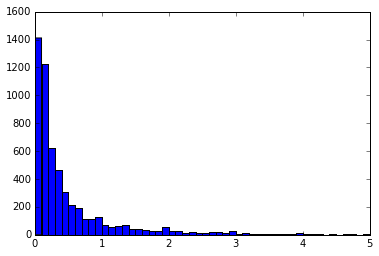

In [36]:
# hist = plt.hist(cnv.values(), bins=100) #, range=(0,100))
print(cnv[cnv.keys()[1000]])
dgr_cnv = [dangerosity(cnv[k]) for k in cnv]
print(np.max(dgr_cnv))
imax = np.argmax(dgr_cnv)
print(cnv.keys()[imax])
h = plt.hist(dgr_cnv, bins=50, range=(0,5))

### Testing dangerosity

In [40]:
for k in range(1,30, 30):
    print(cnv[cnv.keys()[k]], ' yields ', dangerosity(cnv[cnv.keys()[k]]))
    
test_dangerosity_input = [[(1., .5), (1., .5), (1., .5), (1., .5)],
                          [(2., 1.)],
                          [(10000., 0.)]]
test_dangerosity_output = [2., 2., 0]

#print( [dangerosity(icnv) for icnv in test_dangerosity_input]) # == test_dangerosity_output
assert( [dangerosity(icnv) for icnv in test_dangerosity_input] == test_dangerosity_output)

[(0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714), (0.16666666666666663, 0.3218645714285714)]  yields  0.321864571429


### Printing out results

In [45]:
outdir = osp.join(osp.expanduser('~'), 'documents','grants_projects','roberto_projects', \
               'guillaume_huguet_CNV', 'File_OK')
dtime = datetime.now().strftime("%y-%m-%d_h%H-%M")
outfile = dtime + 'dangerosity_cnv_annot_per_gene.txt'

fulloutfile = osp.join(outdir, outfile)

with open(fulloutfile, 'w') as outf:
    for _cnv in cnv:
        outf.write("\t".join([_cnv, str(dangerosity(cnv[_cnv]))]) + "\n")